In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("seaborn-white")
mpl.rcParams['figure.figsize'] = (8, 6)

import os, sys, shutil
sys.path.append("..")
import pandas as pd

from lammpsrun import *
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule, bcc110, bcc111
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)
potential = "boda_manual_sub.reax"
Fe_aq_co2_dir = os.path.join(sim_path, "ferrite_aq_co2")
convert_scripts_dir = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Scripts/"

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


We take ferrite lattice constants as-is: 2.870

# Creating the Simulation Box

## Create the Iron Bits

In [2]:
aq_thickness = 20
n_co2 = 20

In [3]:
Fe_slab = bcc110('Fe', a=2.870, size=(10,14,14), orthogonal=True, vacuum=1.5)
Fe_slab_original_cell = Fe_slab.get_cell()
Fe_slab.set_cell(Fe_slab_original_cell + np.array([[0,0,0],[0,0,0],[0,0,aq_thickness]]))

In [4]:
aq_cell_l100 = np.array([*Fe_slab.get_cell_lengths_and_angles()[:2], aq_thickness])

H2O_l100 = create_water_region(0.995*aq_cell_l100)

np.random.seed(1050027)
ns_remove = np.random.choice(int(H2O_l100.get_number_of_atoms()/3), size=n_co2, replace=False)*3
H2O_l100_co2 = replace_molecule(H2O_l100, ns_remove, molecule('CO2'), cut_off=0.8)

H2O_l100_co2.translate([0, 0, Fe_slab.get_cell_lengths_and_angles()[2]-aq_thickness])

Fe_aq_box = Fe_slab + H2O_l100_co2
Fe_aq_box.set_pbc([True, True, False])
Fe_aq_box

Atoms(symbols='C20H928Fe1960O504', pbc=[True, True, False], cell=[28.700000000000003, 28.411550468075482, 49.38215400607009], tags=...)

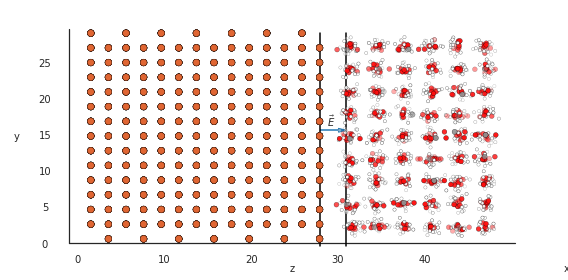

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from ase.data import covalent_radii
from ase.data.colors import cpk_colors, jmol_colors
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(8, 4))

atoms_to_plot = Fe_aq_box

a_num = atoms_to_plot.get_atomic_numbers()
sizes = covalent_radii[a_num]*35
colors = jmol_colors[a_num]
ax_limits = atoms_to_plot.get_cell_lengths_and_angles()[:3]

ax = fig.add_subplot(1, 1, 1, projection='3d', proj_type = 'ortho')
pos = atoms_to_plot.get_positions()

ax.scatter(pos[:, 0], pos[:, 2], pos[:, 1],
           s=sizes,
           c=colors,
           edgecolor='black',
           linewidths=0.3)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.set_xticks([])

ax.plot([0, 0], [Fe_slab_original_cell[2,2]-1.5, Fe_slab_original_cell[2,2]-1.5], [-1, Fe_slab_original_cell[1,1]], c = 'k')
ax.plot([0, 0], [Fe_slab_original_cell[2,2]+1.5, Fe_slab_original_cell[2,2]+1.5], [-1, Fe_slab_original_cell[1,1]], c = 'k')

ax.quiver(0,Fe_slab_original_cell[2,2]-1.5,15,0,3,0)
ax.text(0,Fe_slab_original_cell[2,2]-0.6,15.5, r'$\vec{E}$')

ax.grid(False)

ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.set_xlim3d(0, ax_limits[0])
ax.set_ylim3d(0, ax_limits[2])
ax.set_zlim3d(0, ax_limits[1])
ax.view_init(elev=0, azim=0)
ax.dist = 7
# ax.set_title('{} fs'.format(n))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1,wspace=0, hspace=0)
fig.tight_layout()
fig.savefig('fe_aq_co2_small.png', dpi=400, bbox_inches="tight")
plt.show()

In [7]:
Fe_aq_small_efields = np.array([0.2, 0.3, 0.4, 0.0]) # V/A = 100MV/cm => 0 MV/cm to 45 MV/cm
Fe_aq_small_efields_names = ['Fe_aq_co2_small_short_{:.0f}MVcm'.format(x*100) for x in Fe_aq_small_efields]
efield_boundary = [0-1, Fe_slab_original_cell[0,0]+1, 0-1, Fe_slab_original_cell[1,1]+1, Fe_slab_original_cell[2,2]-1.5, Fe_slab_original_cell[2,2]+1.5]
print(Fe_aq_small_efields_names, efield_boundary)

['Fe_aq_co2_small_short_20MVcm', 'Fe_aq_co2_small_short_30MVcm', 'Fe_aq_co2_small_short_40MVcm', 'Fe_aq_co2_small_short_0MVcm'] [-1, 29.700000000000003, -1, 29.411550468075482, 27.88215400607009, 30.88215400607009]


In [9]:
for sim, efield in zip(Fe_aq_small_efields_names, Fe_aq_small_efields):
    calc = reaxff_params_generator(Fe_aq_box, 
                                   job_name=sim,
                                   write_input=True,
                                   input_fd=Fe_aq_co2_dir,
                                   pair_style= "reax/c NULL safezone 16 efield 0.0 0.0 {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(efield, *efield_boundary),
                                   minimize="1.0e-6 1.0e-6 100 1000",
                                   run=500000,
                                   timestep=0.1,
                                   dump_period=100,
                                   region=["mobile block EDGE EDGE EDGE EDGE 5.0 EDGE side in units box", # neglect bottom few layers
                                           "elec_region block EDGE EDGE EDGE EDGE {:.2f} {:.2f} side in units box".format(*efield_boundary[-2:])], 
                                   group="mobile_g region mobile",
                                   fix=["nvt mobile_g nvt temp 300.0 300.0 10.0",
                                        "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c dual",
                                        "elec all efield 0.0 0.0 {:.2f} region elec_region".format(efield),
                                        "reax_info all reax/c/bonds 100 bonds.tatb",
                                        "zwalls all wall/reflect zlo EDGE zhi EDGE",],
                                   velocity=["all create 300.0 1050027 rot yes mom yes dist gaussian"],
                                   potential=potential)

In [12]:
Fe_aq_small_efields_commands = [["timeout 70h mpiexec /rds/general/user/yx6015/home/lammps/build/lmp -sf omp -pk omp 8 -in {0}.lammpsin -screen none".format(x)] for x in Fe_aq_small_efields_names]
Fe_aq_small_efields_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                                     '$PBS_O_WORKDIR/{}.*'.format(x)] for x in Fe_aq_small_efields_names]

Fe_aq_small_efields_PBS = PBS_Submitter(job_names=Fe_aq_small_efields_names,
                                         job_commands=Fe_aq_small_efields_commands,
                                         modules=["mpi/intel-2018", "intel-suite/2017.6"],
                                         walltime="24:00:00",
                                         proc_nodes=1,
                                         proc_cpus=32, #mpiprocs x threads = cpus
                                         proc_mpiprocs=4,
                                         proc_threads=8,
                                         memory=46,
                                         source_files=Fe_aq_small_efields_source_files)

In [13]:
os.chdir(Fe_aq_co2_dir)

Fe_aq_small_efields_out, Fe_aq_small_efields_err = Fe_aq_small_efields_PBS.run()

os.chdir(sim_path)
print(Fe_aq_small_efields_out, Fe_aq_small_efields_names)

['126448.pbs', '126449.pbs', '126450.pbs', '126451.pbs'] ['Fe_aq_co2_small_short_20MVcm', 'Fe_aq_co2_small_short_30MVcm', 'Fe_aq_co2_small_short_40MVcm', 'Fe_aq_co2_small_short_0MVcm']


In [8]:
for outfile, job_out in zip(Fe_aq_small_efields_names, Fe_aq_small_efields_out):
    shutil.move(os.path.join(Fe_aq_co2_dir, outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(Fe_aq_co2_dir, outfile + ".log"), os.path.join(ephemeral, job_out))

## Post Processing

In [9]:
Fe_aq_small_efields_convert_PBS = trajectory_convert(Fe_aq_small_efields_out, Fe_aq_small_efields_names)
Fe_aq_small_efields_bond_PBS = bond_convert(Fe_aq_small_efields_out, Fe_aq_small_efields_names)

In [10]:
Fe_aq_small_efields_convert_PBS.params['job_commands'] = [[x.replace('32', '8') for x in y] for y in Fe_aq_small_efields_convert_PBS.params['job_commands']]
Fe_aq_small_efields_convert_PBS.params['proc_cpus'] = [8 for y in Fe_aq_small_efields_convert_PBS.params['proc_cpus']]
Fe_aq_small_efields_convert_PBS.params['proc_mpiprocs'] = [8 for y in Fe_aq_small_efields_convert_PBS.params['proc_mpiprocs']]

In [12]:
os.chdir(Fe_aq_co2_dir)

Fe_aq_small_efields_convert_out, Fe_aq_small_efields_convert_err = Fe_aq_small_efields_convert_PBS.run()
Fe_aq_small_efields_bond_out, Fe_aq_small_efields_bond_err = Fe_aq_small_efields_bond_PBS.run()

os.chdir(sim_path)
print("Job Out :", Fe_aq_small_efields_out)
print("Job Name:", Fe_aq_small_efields_names)
print("Conv Out:", Fe_aq_small_efields_convert_out)
print("Bond Out:", Fe_aq_small_efields_bond_out)

Job Out : ['126448.pbs', '126449.pbs', '126450.pbs', '126451.pbs']
Job Name: ['Fe_aq_co2_small_short_20MVcm', 'Fe_aq_co2_small_short_30MVcm', 'Fe_aq_co2_small_short_40MVcm', 'Fe_aq_co2_small_short_0MVcm']
Conv Out: ['134809.pbs', '134810.pbs', '134811.pbs', '134812.pbs']
Bond Out: ['134813.pbs', '134814.pbs', '134815.pbs', '134816.pbs']


In [5]:
Fe_aq_small_efields_out = ['126448.pbs', '126449.pbs', '126450.pbs', '126451.pbs']
Fe_aq_small_efields_names = ['Fe_aq_co2_small_short_20MVcm', 'Fe_aq_co2_small_short_30MVcm', 'Fe_aq_co2_small_short_40MVcm', 'Fe_aq_co2_small_short_0MVcm']
Fe_aq_small_efields_convert_out = ['134809.pbs', '134810.pbs', '134811.pbs', '134812.pbs']
Fe_aq_small_efields_bond_out = ['134813.pbs', '134814.pbs', '134815.pbs', '134816.pbs']

In [13]:
for sim_out, bond_out, convert_out in zip(Fe_aq_small_efields_out, Fe_aq_small_efields_bond_out, Fe_aq_small_efields_convert_out):
    sim_out_files = os.listdir(os.path.join(ephemeral, sim_out))
    bond_files =  os.listdir(os.path.join(ephemeral, bond_out))
    convert_files = os.listdir(os.path.join(ephemeral, convert_out))
    for f in bond_files:
        if f not in sim_out_files: # Do not overwrite existing files
            shutil.move(os.path.join(ephemeral, bond_out, f), os.path.join(ephemeral, sim_out))
            
    for f in convert_files:
        if f not in sim_out_files: # Do not overwrite existing files
            shutil.move(os.path.join(ephemeral, convert_out, f), os.path.join(ephemeral, sim_out))